# Sentiment Analysis with Tensorflow

## Importing dataset

In [1]:
!pip install -q datasets

In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset("rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes_movie_review downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes_movie_review/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In [5]:
#first row of test set
dataset["test"][0]

{'text': 'lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .',
 'label': 1}

## Data Preprocessing
* Language models do not understand texts. They understand numerical data. So we have to tokenize texts.
* Tokenizing means breaking text into smallest pieces and converting them into numerical representations.
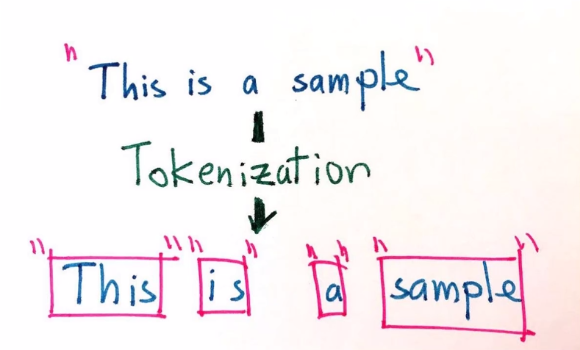

* We will be using BERT based model for sentiment analysis. For data preprocessing, we use tokenizer of this model.

In [6]:
from transformers import AutoTokenizer

In [7]:
tokenizer = AutoTokenizer.from_pretrained(
    "distilbert-base-uncased"
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:
tokenizer(dataset["train"][0]["text"])

{'input_ids': [101, 1996, 2600, 2003, 16036, 2000, 2022, 1996, 7398, 2301, 1005, 1055, 2047, 1000, 16608, 1000, 1998, 2008, 2002, 1005, 1055, 2183, 2000, 2191, 1037, 17624, 2130, 3618, 2084, 7779, 29058, 8625, 13327, 1010, 3744, 1011, 18856, 19513, 3158, 5477, 4168, 2030, 7112, 16562, 2140, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

* Text translated into numerical representations.
* 101 and 102 are special numbers for BERT. 101 shows that text is started and 102 indicates the text is finished.

In [9]:
# This function takes a dictionary of examples as input and tokenizes the "text" field with truncation
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation = True)

In [10]:
# Converting the entire data set's "text" column to numerical representations
dataset = dataset.map(preprocess_function, batched = True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [11]:
# synchronize lengths of data
from transformers import DataCollatorWithPadding

In [12]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = "tf")

## Loading Model

In [13]:
from transformers import TFAutoModelForSequenceClassification

In [14]:
my_model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [20]:
# Preparing the training dataset as a TensorFlow dataset
tf_train_set = my_model.prepare_tf_dataset(
    dataset["train"],
    shuffle = True,
    batch_size = 16,
    collate_fn = data_collator
)

AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [18]:
# Preparing the validation dataset as a TensorFlow dataset
tf_validation_set = my_model.prepare_tf_dataset(
    dataset["validation"],
    shuffle = False,
    batch_size = 16,
    collate_fn = data_collator
)

AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Model Training
* Let's compile the model using the Adam optimizer with a learning rate of 3e-5.

In [22]:
from tensorflow.keras.optimizers import Adam

In [23]:
my_model.compile(optimizer = Adam(3e-5))

In [ ]:
my_model.fit(
    x = tf_train_set,
    validation_data = tf_validaiton_set,
    epochs = 2
)

## Prediction

In [24]:
text = "I love NLP. It's fun to analyze NLP tasks with HuggingFace"

In [25]:
# tokenize the text
tokenized_text = tokenizer(text, return_tensors = "tf")
tokenized_text

{'input_ids': <tf.Tensor: shape=(1, 19), dtype=int32, numpy=
array([[  101,  1045,  2293, 17953,  2361,  1012,  2009,  1005,  1055,
         4569,  2000, 17908, 17953,  2361,  8518,  2007, 17662, 12172,
          102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 19), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
      dtype=int32)>}

In [ ]:
logits = my_model(**tokenized_text).logits

In [26]:
#highest prediction
from tensorflow import math

In [ ]:
int(math.argmax(logits, axis = -1)[0])